In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import re
import warnings
from scipy.sparse import spdiags
from scipy import signal
from scipy.signal import butter
import scipy

%matplotlib inline

# Try importing ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
except ImportError as e:
    widgets = None
    print("ipywidgets is not available in this environment. Interactive features will be disabled.")

In [6]:
# FILL THIS IN! This is the path to your preprocessed dataset folder.
preprocessed_dataset_path = 'A:/My_project/rPPG-Toolbox/PreprocessedData/UBFC_test_data'

input_files = [filename for filename in os.listdir(preprocessed_dataset_path) if filename.endswith(".npy") and re.match(r".*input\d+\.npy", filename)]
label_files = [input_file.replace("input", "label") for input_file in input_files if input_file.replace("input", "label") in os.listdir(preprocessed_dataset_path)]

if len(input_files) == 0 or len(label_files) == 0:
    print("Error: No valid input or label files found in the directory.")
else:
    print(f"{len(input_files)} input files and {len(label_files)} label files detected.")

439 input files and 439 label files detected.


In [7]:
class Visualizer:
    def __init__(self, preprocessed_dataset_path, input_files, label_files):
        self.input_files = sorted(input_files)
        self.label_files = sorted(label_files)
        self.chunk_dropdown = None
        self.fig = None
        self.ax = None
        self.frame_index_slider = None
        self.current_chunk_index = 0
        self.current_frame_index = 0
        self.dataset_path = preprocessed_dataset_path
        self.avg_heart_rate = None

        self.diff_flag = "DiffNormalized" in preprocessed_dataset_path

        # Only initialize widgets if the library is available
        if widgets:
            self.create_visualization()
        else:
            print("Running in a non-widget environment. Visualization will be non-interactive.")

    def create_visualization(self):
        self.create_dropdown()
        self.create_figure()
        self.create_slider()

    def create_dropdown(self):
        # Check if widgets are available
        if widgets:
            self.chunk_dropdown = widgets.Dropdown(
                options=self.input_files,
                description='Chunk:',
                layout=widgets.Layout(width='800px'),
                value=None
            )
            self.chunk_dropdown.observe(self.chunk_selection_changed, names='value')

            display(self.chunk_dropdown)
        else:
            print("Dropdown cannot be displayed: ipywidgets not available.")

    def create_figure(self):
        self.fig, self.ax = plt.subplots(figsize=(8, 4))
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        plt.tight_layout()

    def create_slider(self):
        if widgets:
            num_frames = self.get_num_frames()
            self.frame_index_slider = widgets.IntSlider(
                min=0,
                max=num_frames - 1,
                step=1,
                value=0,
                description='Frame:',
                layout=widgets.Layout(width='800px')
            )
            self.frame_index_slider.observe(self.frame_index_changed, names='value')

            display(self.frame_index_slider)
        else:
            print("Slider cannot be displayed: ipywidgets not available.")

    def chunk_selection_changed(self, change):
        selected_chunk = change.new
        self.current_chunk_index = self.input_files.index(selected_chunk)
        self.current_frame_index = 0
        if self.frame_index_slider:
            self.frame_index_slider.value = 0
        self.update_frame()

    def frame_index_changed(self, change):
        self.current_frame_index = change.new
        self.update_frame()

    def get_num_frames(self):
        input_file = self.input_files[self.current_chunk_index]
        return np.load(os.path.join(self.dataset_path, input_file)).shape[0]

    def load_frame(self):
        input_file = self.input_files[self.current_chunk_index]
        input_data = np.load(os.path.join(self.dataset_path, input_file))
        print(f'The shape of the loaded chunk is {np.shape(input_data)}.')

        if input_data.shape[-1] == 6:
            rgb_frames = input_data[..., 3:]
            diff_normalized_frames = input_data[..., :3]

            # Create a side-by-side visualization
            frame = np.concatenate((rgb_frames, diff_normalized_frames), axis=2)
        elif input_data.shape[-1] == 3:
            # Use RGB frames directly for visualization
            frame = input_data
        else:
            raise ValueError("Invalid input_data shape. Expected shape (..., 3) or (..., 6).")

        return frame[self.current_frame_index]

    def load_label_frame(self):
        """
        Load the corresponding label data for the currently selected chunk.
        This method assumes the labels are stored in .npy files and are aligned
        with the input files in the same folder.
        """
        label_file = self.label_files[self.current_chunk_index]
        label_data = np.load(os.path.join(self.dataset_path, label_file))
        print(f'The shape of the loaded label file is {np.shape(label_data)}.')

        # Process the signal as needed (e.g., detrending, filtering)
        label_data = self._process_signal(label_data)

        return label_data

    def _process_signal(self, signal):
        """
        A helper function to process the signal (e.g., detrend and filter the PPG signal).
        You can adapt this based on your signal processing needs.
        """
        fs = 30  # Sampling frequency
        use_bandpass = True

        # Detrend signal or its cumulative sum based on diff_flag
        if self.diff_flag:
            # If the predictions and labels are the 1st derivative of the PPG signal
            detrended_signal = self._detrend(np.cumsum(signal), 100)
        else:
            # Detrend the original signal
            detrended_signal = self._detrend(signal, 100)

        # Apply bandpass filter if needed
        if use_bandpass:
            # Bandpass filter between [0.75, 2.5] Hz (45-150 bpm)
            b, a = butter(1, [0.75 / fs * 2, 2.5 / fs * 2], btype='bandpass')
            filtered_signal = scipy.signal.filtfilt(b, a, np.double(detrended_signal))
            return filtered_signal

        return detrended_signal

    def _detrend(self, input_signal, lambda_value):
        """
        Detrend the input signal.
        This method removes long-term trends from the signal using a smoothing filter.
        """
        signal_length = input_signal.shape[0]
        H = np.identity(signal_length)
        ones = np.ones(signal_length)
        minus_twos = -2 * np.ones(signal_length)
        diags_data = np.array([ones, minus_twos, ones])
        diags_index = np.array([0, 1, 2])
        D = spdiags(diags_data, diags_index, signal_length - 2, signal_length).toarray()

        # Apply smoothing
        detrended_signal = np.dot(
            (H - np.linalg.inv(H + (lambda_value ** 2) * np.dot(D.T, D))), input_signal
        )
        return detrended_signal

    def create_label_figure(self):
        # Create figure with two subplots: time-domain and frequency-domain
        self.label_fig, (self.label_ax_time, self.label_ax_fft) = plt.subplots(2, 1, figsize=(8, 6))
        self.label_ax_time.set_xlabel('Frame #')
        self.label_ax_time.set_ylabel('Magnitude')
        self.label_ax_fft.set_xlabel('Frequency')
        self.label_ax_fft.set_ylabel('Magnitude')

    def update_label_frame(self):
        def _next_power_of_2(x):
            """Calculate the nearest power of 2."""
            return 1 if x == 0 else 2 ** (x - 1).bit_length()

        clear_output(wait=True)

        label_frame = self.load_label_frame()

        # Zero-padding the signal to improve frequency resolution
        N = _next_power_of_2(label_frame.shape[0])
        fs = 30  # Sampling frequency
        ppg_label_fft = label_frame
        
        ppg_label_f, ppg_label_pxx = signal.periodogram(ppg_label_fft, fs=fs, nfft=N, detrend=False)

        # Find the frequency corresponding to the highest power within the heart rate range (0.75 - 2.5 Hz)
        heart_rate_range = (0.75, 2.5)
        idx = np.where((ppg_label_f >= heart_rate_range[0]) & (ppg_label_f <= heart_rate_range[1]))[0]
        dominant_frequency = ppg_label_f[idx[np.argmax(ppg_label_pxx[idx])]]
        self.avg_heart_rate = dominant_frequency * 60  # Convert Hz to bpm (beats per minute)

        # Clear the figure to prevent double visualization
        self.label_fig.clear()

        # Create the time-domain plot
        self.label_ax_time = self.label_fig.add_subplot(211)  # First subplot for time-domain
        self.label_ax_time.plot(label_frame)
        self.label_ax_time.set_xlabel('Frame #')
        self.label_ax_time.set_ylabel('Magnitude')

        # Create the frequency-domain plot
        self.label_ax_fft = self.label_fig.add_subplot(212)  # Second subplot for frequency-domain
        self.label_ax_fft.plot(ppg_label_f, ppg_label_pxx / ppg_label_pxx.max())
        self.label_ax_fft.set_xlabel('Frequency (Hz)')
        self.label_ax_fft.set_ylabel('Magnitude')
        self.label_ax_fft.set_xlim([0, 5])  # Limit the x-axis to relevant frequencies (0-5 Hz)

        self.label_fig.suptitle(self.label_files[self.current_chunk_index], y=1.02)
        self.label_fig.tight_layout()

        # Display the average heart rate as standalone text below the entire figure
        self.label_fig.text(0.5, -0.05, f'Average Heart Rate: {self.avg_heart_rate:.2f} bpm',
                            ha='center', va='center', fontsize=16, color='red', weight='bold')

    def update_frame(self):
        clear_output(wait=True)

        self.fig.clear()

        frame = self.load_frame()

        # Recreate the axes for the figure and draw the image
        self.ax = self.fig.add_subplot(111)
        self.ax.imshow(frame)

        self.ax.set_xticks([])
        self.ax.set_yticks([])

        self.ax.set_title(f"{self.input_files[self.current_chunk_index]} - Frame {self.current_frame_index}")

        self.fig.tight_layout()

        self.update_label_frame()

        display(self.chunk_dropdown, self.frame_index_slider, self.fig)

    def update_frame(self):
        clear_output(wait=True)

        self.fig.clear()  # This ensures the whole figure is cleared before re-drawing

        frame = self.load_frame()

        # Recreate the axes for the figure and draw the image
        self.ax = self.fig.add_subplot(111)
        self.ax.imshow(frame)

        self.ax.set_xticks([])
        self.ax.set_yticks([])

        self.ax.set_title(f"{self.input_files[self.current_chunk_index]} - Frame {self.current_frame_index}")

        self.fig.tight_layout()

        self.update_label_frame()

        display(self.chunk_dropdown, self.frame_index_slider, self.fig, self.label_fig)

Dropdown(description='Chunk:', index=10, layout=Layout(width='800px'), options=('subject10_input0.npy', 'subje…

IntSlider(value=0, description='Frame:', layout=Layout(width='800px'), max=179)

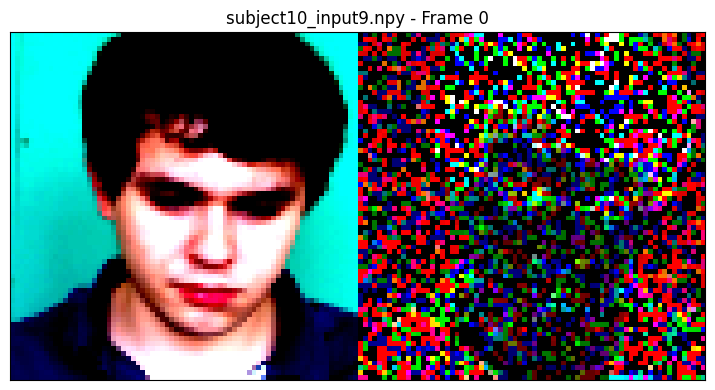

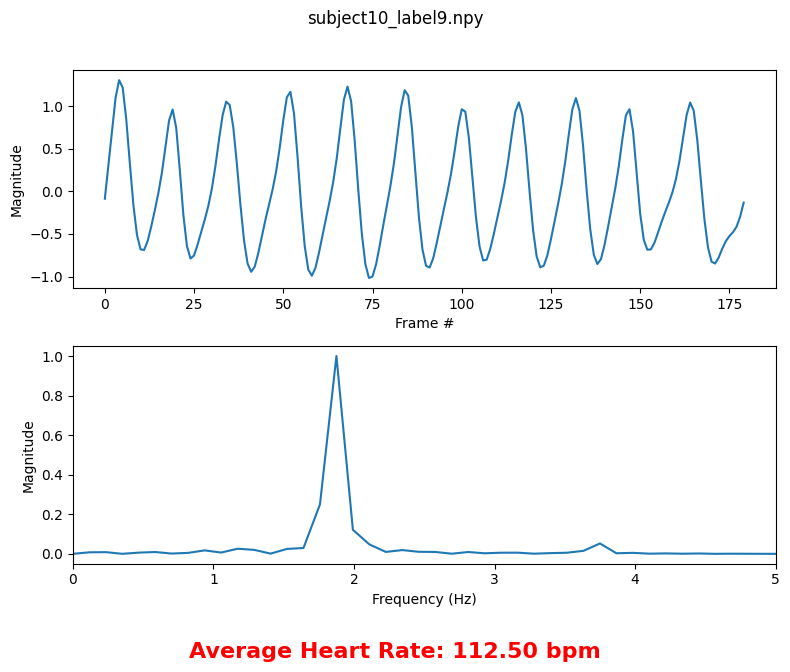

In [ ]:
# Create the visualizer instance
visualizer = Visualizer(preprocessed_dataset_path, input_files, label_files)

# Create the label figure
visualizer.create_label_figure()